In [2]:
from __future__ import division
import time
import torch 
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2 
from util import *
from darknet import Darknet
from preprocess import prep_image, inp_to_image, letterbox_image
import pandas as pd
import random 
import pickle as pkl
import argparse


def get_test_input(input_dim, CUDA):
    img = cv2.imread("dog-cycle-car.png")
    img = cv2.resize(img, (input_dim, input_dim)) 
    img_ =  img[:,:,::-1].transpose((2,0,1))
    img_ = img_[np.newaxis,:,:,:]/255.0
    img_ = torch.from_numpy(img_).float()
    img_ = Variable(img_)
    
    if CUDA:
        img_ = img_.cuda()
    
    return img_

def prep_image(img, inp_dim):
    """
    Prepare image for inputting to the neural network. 
    
    Returns a Variable 
    """

    orig_im = img
    dim = orig_im.shape[1], orig_im.shape[0]
    img = (letterbox_image(orig_im, (inp_dim, inp_dim)))
    img_ = img[:,:,::-1].transpose((2,0,1)).copy()
    img_ = torch.from_numpy(img_).float().div(255.0).unsqueeze(0)
    return img_, orig_im, dim

def write(x, img):
    c1 = tuple(x[1:3].int())
    c2 = tuple(x[3:5].int())
    cls = int(x[-1])
    label = "{0}".format(classes[cls])
    color = random.choice(colors)
    cv2.rectangle(img, c1, c2,color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1);
    return img

def arg_parse():
    """
    Parse arguements to the detect module
    
    """
    
    
    parser = argparse.ArgumentParser(description='YOLO v3 Video Detection Module')
   
    parser.add_argument("--video", dest = 'video', help = 
                        "Video to run detection upon",
                        default = "video.avi", type = str)
    parser.add_argument("--dataset", dest = "dataset", help = "Dataset on which the network has been trained", default = "pascal")
    parser.add_argument("--confidence", dest = "confidence", help = "Object Confidence to filter predictions", default = 0.5)
    parser.add_argument("--nms_thresh", dest = "nms_thresh", help = "NMS Threshhold", default = 0.4)
    parser.add_argument("--cfg", dest = 'cfgfile', help = 
                        "Config file",
                        default = "cfg/yolov3.cfg", type = str)
    parser.add_argument("--weights", dest = 'weightsfile', help = 
                        "weightsfile",
                        default = "yolov3.weights", type = str)
    parser.add_argument("--reso", dest = 'reso', help = 
                        "Input resolution of the network. Increase to increase accuracy. Decrease to increase speed",
                        default = "416", type = str)
    return parser.parse_args()




ModuleNotFoundError: No module named 'util'

In [6]:


confidence = float(0.7)
nms_thesh = float(0.4)
start = 0

CUDA = torch.cuda.is_available()

num_classes = 80

CUDA = torch.cuda.is_available()

bbox_attrs = 5 + num_classes

print("Loading network.....")
model = Darknet(args.cfgfile)
model.load_weights(args.weightsfile)
print("Network successfully loaded")

model.net_info["height"] = args.reso
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0 
assert inp_dim > 32

if CUDA:
    model.cuda()

model(get_test_input(inp_dim, CUDA), CUDA)

model.eval()

videofile = args.video

cap = cv2.VideoCapture(videofile)

assert cap.isOpened(), 'Cannot capture source'

frames = 0
start = time.time()    
while cap.isOpened():

    ret, frame = cap.read()
    if ret:


        img, orig_im, dim = prep_image(frame, inp_dim)

        im_dim = torch.FloatTensor(dim).repeat(1,2)                        


        if CUDA:
            im_dim = im_dim.cuda()
            img = img.cuda()

        with torch.no_grad():   
            output = model(Variable(img), CUDA)
        output = write_results(output, confidence, num_classes, nms = True, nms_conf = nms_thesh)

        if type(output) == int:
            frames += 1
            print("FPS of the video is {:5.2f}".format( frames / (time.time() - start)))
            cv2.imshow("frame", orig_im)
            key = cv2.waitKey(1)
            if key & 0xFF == ord('q'):
                break
            continue




        im_dim = im_dim.repeat(output.size(0), 1)
        scaling_factor = torch.min(inp_dim/im_dim,1)[0].view(-1,1)

        output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim[:,0].view(-1,1))/2
        output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim[:,1].view(-1,1))/2

        output[:,1:5] /= scaling_factor

        for i in range(output.shape[0]):
            output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim[i,0])
            output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim[i,1])

        classes = load_classes('data/coco.names')
        colors = pkl.load(open("pallete", "rb"))

        list(map(lambda x: write(x, orig_im), output))


        cv2.imshow("frame", orig_im)
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q'):
            break
        frames += 1
        print("FPS of the video is {:5.2f}".format( frames / (time.time() - start)))


    else:
        break








usage: ipykernel_launcher.py [-h] [--video VIDEO] [--dataset DATASET]
                             [--confidence CONFIDENCE]
                             [--nms_thresh NMS_THRESH] [--cfg CFGFILE]
                             [--weights WEIGHTSFILE] [--reso RESO]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/Eren/Library/Jupyter/runtime/kernel-16db8a81-c358-43b1-a8db-14ac9259388c.json


SystemExit: 2

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Load Dependencies

In [1]:

# Some code sourced from:

#############################################
# Object detection - YOLO - OpenCV
# Author : Arun Ponnusamy   (July 16, 2018)
# Website : http://www.arunponnusamy.com
############################################


import cv2
import numpy as np
import matplotlib.pyplot as plt


import pandas as pd


from scipy.spatial import distance
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras import backend as K


%matplotlib inline





Using TensorFlow backend.


# Functions

In [2]:




def get_output_layers(net):
    
    layer_names = net.getLayerNames()
    
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers


def draw_prediction(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


def get_yolo_output(image):

    Width = image.shape[1]
    Height = image.shape[0]
    scale = 0.00392

    blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

    net.setInput(blob)

    outs = net.forward(get_output_layers(net))


    class_ids = []
    confidences = []
    boxes = []
    conf_threshold = 0.5
    nms_threshold = 0.4


    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])


    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    
    boxes_nms = []
    class_ids_nms = []
    confidences_nms = []
    
    
    for i in indices:
        i = i[0]
        boxes_nms.append(boxes[i])
        class_ids_nms.append(class_ids[i])
        confidences_nms.append(confidences[i])
    
    return boxes_nms, class_ids_nms, confidences_nms


def print_on_image(image, boxes_nms, class_ids_nms, confidences_nms):

    #cv2.polylines(image,swalk_pts,True,(0,255,255),thickness=3)
    #cv2.polylines(image,lane_pts,True,(255,0,255),thickness=3)
    
    
    for i, box in enumerate(boxes_nms):
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]
        draw_prediction(image, class_ids_nms[i], confidences_nms[i], round(x), round(y), round(x+w), round(y+h))
        

        
def create_grid_image(boxes_nms, class_ids_nms, confidences_nms, grid_scaling_factor, grid_background):
    
    
    grid_vehicles   = np.zeros((grid_y_size,grid_x_size), dtype = np.int8)
    grid_person     = np.zeros((grid_y_size,grid_x_size), dtype = np.int8)
    grid_bicycle    = np.zeros((grid_y_size,grid_x_size), dtype = np.int8)
    
    for i, box in enumerate(boxes_nms):

        x = round(box[0])
        y = round(box[1])
        w = box[2]
        h = box[3]

        x_plus_w = round(x+w)
        y_plus_h = round(y+h)


        x = round(x/grid_scaling_factor)
        y = round(y/grid_scaling_factor)
        x_plus_w = round(x_plus_w/grid_scaling_factor)
        y_plus_h = round(y_plus_h/grid_scaling_factor)
        
        if class_ids_nms[i] in [2, 3, 5, 6, 7]:  # Motorized vehicles [car, motorcycle, bus, train, truck]
            
            cv2.rectangle(grid_vehicles, (x,y), (x_plus_w,y_plus_h), vehicle_w, -1)


        elif class_ids_nms[i]==0:  # Person
            
            cv2.rectangle(grid_person, (x,y), (x_plus_w,y_plus_h), person_w, -1) 
            
        elif class_ids_nms[i]==1:  # Bicycle
            
            cv2.rectangle(grid_bicycle, (x,y), (x_plus_w,y_plus_h), bicycle_w, -1)
            
        else:
            continue
    
    grid_overflow = np.zeros((grid_y_size,grid_x_size), dtype = np.int16)    
    #grid_overflow = np.array([grid_background,grid_vehicles,grid_person,grid_bicycle])
    grid_overflow = np.array([grid_vehicles,grid_person,grid_bicycle])
    grid_overflow = grid_overflow.sum(axis=0)
    grid_overflow[grid_overflow>127] = 127
    grid_overflow[grid_overflow<-128] = -128
    grid = np.array(grid_overflow,dtype=np.int8)

    return grid
       

    
def create_grid(boxes_nms, class_ids_nms, confidences_nms, grid_scaling_factor, grid_background,
               vehicles=False,
               persons=False,
               bicycles=False):
    
    options = [vehicles, persons, bicycles]
    num_channels = options.count(True)
    
    grid = np.zeros((num_channels,grid_y_size,grid_x_size), dtype = bool)
    
    
    grid_vehicles   = np.zeros((grid_y_size,grid_x_size), dtype = bool)
    grid_person     = np.zeros((grid_y_size,grid_x_size), dtype = bool)
    grid_bicycle    = np.zeros((grid_y_size,grid_x_size), dtype = bool)
    
    present_val = 1
    
    for i, box in enumerate(boxes_nms):

        x = round(box[0])
        y = round(box[1])
        w = box[2]
        h = box[3]

        x_plus_w = round(x+w)
        y_plus_h = round(y+h)


        x = round(x/grid_scaling_factor)
        y = round(y/grid_scaling_factor)
        x_plus_w = round(x_plus_w/grid_scaling_factor)
        y_plus_h = round(y_plus_h/grid_scaling_factor)
        
        
        if class_ids_nms[i] in [2, 3, 5, 6, 7]:  # Motorized vehicles [car, motorcycle, bus, train, truck]
            
            grid_vehicles[y:y_plus_h+1,x:x_plus_w+1] = present_val

        elif class_ids_nms[i]==0:  # Person
            
            grid_person[y:y_plus_h+1,x:x_plus_w+1] = present_val
            
        elif class_ids_nms[i]==1:  # Bicycle
            
            grid_bicycle[y:y_plus_h+1,x:x_plus_w+1] = present_val
            
        else:
            continue


    j = 0
    if vehicles:
        grid[j] = grid_vehicles
        j = j+1
    if persons:
        grid[j] = grid_person
        j = j+1
    if bicycles:
        grid[j] = grid_bicycle
        j = j+1
    
    return grid
       



# Spatial and Time Scaling Coefficients
* "seconds" represents the time intervals in seconds at which samples will be taken from the video.    
* "grid_scaling_factor" represents the factor by which the grid will be shrunk.

In [3]:
seconds = 0.25
grid_scaling_factor = 32

# Background Areas

In [4]:

########### Background Areas #############

#lanes

lane_pts = []
lane_pts_1 = np.array([[540,0],[483,303],[314,555],[0,915],[0,1080],[625,1080],[708,719],[745,544],[763,362],[687,154],[791,310],[822,396],[835,582],[806,861],[779,1080],[1114,1080],[1060,664],[988,418],[924,317],[662,0]], np.int32)
lane_pts_1 = lane_pts_1.reshape((-1,1,2))

lane_pts_2 = np.array([[1920,600],[1832,660],[1760,773],[1692,907],[1660,1080],[1140,1080],[1245,893],[1418,691],[1590,569],[1782,480],[1920,421]], np.int32)
lane_pts_2 = lane_pts_2.reshape((-1,1,2))

lane_pts.append(lane_pts_1)
lane_pts.append(lane_pts_2)


lane_pts_grid = []

for pts in lane_pts:
    grid_pts = np.divide(pts,grid_scaling_factor)
    np.round_(grid_pts)
    grid_pts = np.array(grid_pts,dtype=np.int32)
    lane_pts_grid.append(grid_pts)



#sidewalks

swalk_pts = []
swalk_pts_1 = np.array([[454,0],[540,0],[514,143],[448,149],[383,306],[483,303],[314,555],[0,915],[0,425],[179,356]], np.int32)
swalk_pts_1 = swalk_pts_1.reshape((-1,1,2))

swalk_pts_2 = np.array([[986,265],[1173,264],[1268,319],[1484,291],[1600,296],[1920,224],[1920,281],[1280,529],[1151,500]], np.int32)
swalk_pts_2 = swalk_pts_2.reshape((-1,1,2))

swalk_pts_3 = np.array([[1920,600],[1920,1080],[1660,1080],[1692,907],[1760,773],[1832,660]], np.int32)
swalk_pts_3 = swalk_pts_3.reshape((-1,1,2))


swalk_pts.append(swalk_pts_1)
swalk_pts.append(swalk_pts_2)
swalk_pts.append(swalk_pts_3)


swalk_pts_grid = []

for pts in swalk_pts:
    grid_pts = np.divide(pts,grid_scaling_factor)
    np.round_(grid_pts)
    grid_pts = np.array(grid_pts,dtype=np.int32)
    swalk_pts_grid.append(grid_pts)
    


#out of bounds (oob) areas


#median spaces



## Grid Weights

In [5]:

########### Grid Weights #############


lane_w = 32
swalk_w = -32
oob_w = -127
med_sp_w = 0


vehicle_w = 64
person_w = -64
bicycle_w = 32

# obj_w = 




## Load Model

In [6]:

##################################################################### 

classes = None

with open('yolov3.txt', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

GREYSCALE = np.random.uniform(0, 255, size=(len(classes)))

net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')


#image = cv2.imread('dog.jpg')

#####################################################################




## Load Video

In [7]:





videofile = 'videos/FYP_Traffic_Footage_Embankment.mp4'

cap = cv2.VideoCapture(videofile)

assert cap.isOpened(), 'Cannot capture source'

frameId = int(round(cap.get(1))) #current frame number, rounded b/c sometimes you get frame intervals which aren't integers...this adds a little imprecision but is likely good enough
success,image = cap.read()



fps = cap.get(cv2.CAP_PROP_FPS) # Gets the frames per second
num_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT) # Gets the total number of frames




frame_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH) # Gets the frame width
frame_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT) # Gets the frame width

grid_x_size = int(round(frame_width/grid_scaling_factor))
grid_y_size = int(round(frame_height/grid_scaling_factor))


multiplier = int(round(fps * seconds))
num_scenes = int(round(num_frames/(fps * seconds))+1)


grids_v       = np.zeros((num_scenes,1,grid_y_size,grid_x_size), dtype = bool)
grids_p       = np.zeros((num_scenes,1,grid_y_size,grid_x_size), dtype = bool)
grids_vp      = np.zeros((num_scenes,2,grid_y_size,grid_x_size), dtype = bool)
grids_vpb     = np.zeros((num_scenes,3,grid_y_size,grid_x_size), dtype = bool)


frameIds    = np.zeros((num_scenes), dtype = np.int32)
time_sec_count = np.zeros((num_scenes), dtype = np.int32)


#################### Initiate Process ################

#################### Create Background Grid ################

grid_background = np.zeros((grid_y_size,grid_x_size), dtype = np.int8)

# Mark background
cv2.fillPoly(grid_background,lane_pts_grid,lane_w)
cv2.fillPoly(grid_background,swalk_pts_grid,swalk_w)

print('FPS: ', fps)



FPS:  23.976023976023978


## Process Video

In [8]:


############################################################

i = 0

while success:

    if frameId % multiplier == 0:
        

        
#############################################################

        
        boxes_nms, class_ids_nms, confidences_nms = get_yolo_output(image)
        
        second_count = round(frameId/fps)
        
        
        grid = create_grid(boxes_nms, class_ids_nms, confidences_nms, grid_scaling_factor,grid_background,
                           vehicles = True,
                           persons = True,
                           bicycles = True)
        
        
        
        grids_v[i] = grid[0]
        grids_p[i] = grid[1]
        grids_vp[i] = grid[:2]
        grids_vpb[i] = grid
        
        
        
        frameIds[i] = frameId
        time_sec_count[i] = second_count
        
        
        
        
        
        
        if frameId % (40*multiplier) == 0:
            
            print ('Time processed = ', int(second_count/60), ' mins ', second_count%60, ' seconds')
            
            
            grid_rep = np.array(grid[1],dtype=np.uint8)
            grid_rep = np.multiply(grid_rep,255)
            cv2.imwrite("output/representations/rep%d.jpg" % frameId, grid_rep)
        
            grid_image = create_grid_image(boxes_nms, class_ids_nms, confidences_nms, grid_scaling_factor,grid_background)
            grid_image_16_bit = np.array(grid_image,dtype=np.int16)
            grid_image_16_bit = np.add(grid_image_16_bit,128)
            grid_image_unsigned = np.array(grid_image_16_bit,dtype=np.uint8)
            cv2.imwrite("output/grids/grid%d.jpg" % frameId, grid_image_unsigned)

            print_on_image(image, boxes_nms, class_ids_nms, confidences_nms)

            cv2.imwrite("output/frames/frame%d.jpg" % frameId, image)
        
        
        i= i+1
        
        #print ('One image done')
        
        
    frameId = int(round(cap.get(1))) #current frame number, rounded b/c sometimes you get frame intervals which aren't integers...this adds a little imprecision but is likely good enough
    success, image = cap.read()


        #plt.figure(figsize = (15, 15))
        #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    
#cv2.imwrite("object-detection.jpg", image)
#cv2.destroyAllWindows()

print (i)

cap.release()



print ("Complete")





Time processed =  0  mins  0  seconds
Time processed =  0  mins  10  seconds
Time processed =  0  mins  20  seconds
Time processed =  0  mins  30  seconds
Time processed =  0  mins  40  seconds
Time processed =  0  mins  50  seconds
Time processed =  1  mins  0  seconds
Time processed =  1  mins  10  seconds
Time processed =  1  mins  20  seconds
Time processed =  1  mins  30  seconds
Time processed =  1  mins  40  seconds
Time processed =  1  mins  50  seconds
Time processed =  2  mins  0  seconds
Time processed =  2  mins  10  seconds
Time processed =  2  mins  20  seconds
Time processed =  2  mins  30  seconds
Time processed =  2  mins  40  seconds
Time processed =  2  mins  50  seconds
Time processed =  3  mins  0  seconds
Time processed =  3  mins  10  seconds
Time processed =  3  mins  20  seconds
Time processed =  3  mins  30  seconds
Time processed =  3  mins  40  seconds
Time processed =  3  mins  50  seconds
Time processed =  4  mins  0  seconds
Time processed =  4  mins  10 

Time processed =  34  mins  42  seconds
Time processed =  34  mins  52  seconds
Time processed =  35  mins  2  seconds
Time processed =  35  mins  12  seconds
Time processed =  35  mins  22  seconds
Time processed =  35  mins  32  seconds
Time processed =  35  mins  42  seconds
Time processed =  35  mins  52  seconds
Time processed =  36  mins  2  seconds
Time processed =  36  mins  12  seconds
Time processed =  36  mins  22  seconds
Time processed =  36  mins  32  seconds
Time processed =  36  mins  42  seconds
Time processed =  36  mins  52  seconds
Time processed =  37  mins  2  seconds
Time processed =  37  mins  12  seconds
Time processed =  37  mins  22  seconds
Time processed =  37  mins  32  seconds
Time processed =  37  mins  42  seconds
Time processed =  37  mins  52  seconds
Time processed =  38  mins  2  seconds
Time processed =  38  mins  12  seconds
Time processed =  38  mins  22  seconds
Time processed =  38  mins  32  seconds
Time processed =  38  mins  42  seconds
Time

In [9]:
np.save("grid_arrays/grids_v.npy", grids_v)
np.save("grid_arrays/grids_p.npy", grids_p)
np.save("grid_arrays/grids_vp.npy", grids_vp)
np.save("grid_arrays/grids_vpb.npy", grids_vpb)

np.save("grid_arrays/frameIds.npy", frameIds)
np.save("grid_arrays/time_sec_count.npy", time_sec_count)

# Optical Flow

In [116]:
import time
import skimage.measure

In [117]:
optflow_procc_scale=8
averaging_scale = 2

grids_flow     = np.zeros((num_scenes,grid_y_size,grid_x_size,2), dtype = np.float32)
print(grids_flow.shape)

(16414, 34, 60, 2)


In [118]:
cap = cv2.VideoCapture(videofile)

assert cap.isOpened(), 'Cannot capture source'

frameId = int(round(cap.get(1))) #current frame number, rounded b/c sometimes you get frame intervals which aren't integers...this adds a little imprecision but is likely good enough
success,image1 = cap.read()
image1 = cv2.resize(image1,(optflow_procc_scale*grid_x_size,optflow_procc_scale*grid_y_size))
print(image1.shape)

prvs = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(image1)
hsv[...,1] = 255




(272, 480, 3)


In [119]:

cv2.imwrite("resized_image.jpg", image1)

True

In [120]:
start = time.time()

############################################################

i = 0

while success:
    
    success,image2 = cap.read()
    if success:
        image2 = cv2.resize(image2,(optflow_procc_scale*grid_x_size,optflow_procc_scale*grid_y_size))
    

        if frameId % multiplier == 0:





            nxt = cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)
            prvs = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
            flow = cv2.calcOpticalFlowFarneback(prvs,nxt, None, 0.5, 3, 15, 3, 5, 1.2, 0)










    #############################################################



            second_count = round(frameId/fps)
        
            flow_resize = skimage.measure.block_reduce(flow,        (averaging_scale,averaging_scale,1), np.mean)
            flow_resize = skimage.measure.block_reduce(flow_resize, (int(round(optflow_procc_scale/averaging_scale)),int(round(optflow_procc_scale/averaging_scale)),1), np.max)

            grids_flow[i] = flow_resize










            if frameId % (40*multiplier) == 0:

                print ('Time processed = ', int(second_count/60), ' mins ', second_count%60, ' seconds')

                end = time.time()
                print('Time elapsed : ', end-start, ' s')
                start = time.time()

                mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
                hsv[...,0] = ang*180/np.pi/2
                hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
                bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)


                cv2.imwrite("output/optical_flow/flow%d.jpg" % frameId, bgr)

                end_write = time.time()
                print('Time for image write : ', end_write-start, ' s')


            i= i+1

            #print ('One image done')
        
        
    frameId = int(round(cap.get(1))) #current frame number, rounded b/c sometimes you get frame intervals which aren't integers...this adds a little imprecision but is likely good enough
    
    image1 = image2


        #plt.figure(figsize = (15, 15))
        #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    
#cv2.imwrite("object-detection.jpg", image)
#cv2.destroyAllWindows()

print (i)

cap.release()



print ("Complete")






Time processed =  0  mins  0  seconds
Time elapsed :  0.06475996971130371  s
Time for image write :  0.012840986251831055  s
Time processed =  0  mins  10  seconds
Time elapsed :  3.380337953567505  s
Time for image write :  0.005681037902832031  s
Time processed =  0  mins  20  seconds
Time elapsed :  3.0655789375305176  s
Time for image write :  0.005239963531494141  s
Time processed =  0  mins  30  seconds
Time elapsed :  3.080430030822754  s
Time for image write :  0.004461050033569336  s
Time processed =  0  mins  40  seconds
Time elapsed :  3.0654098987579346  s
Time for image write :  0.00535893440246582  s
Time processed =  0  mins  50  seconds
Time elapsed :  3.0464138984680176  s
Time for image write :  0.005504131317138672  s
Time processed =  1  mins  0  seconds
Time elapsed :  3.0410873889923096  s
Time for image write :  0.004439830780029297  s
Time processed =  1  mins  10  seconds
Time elapsed :  3.114241123199463  s
Time for image write :  0.0046808719635009766  s
Time

Time processed =  11  mins  1  seconds
Time elapsed :  3.2921531200408936  s
Time for image write :  0.0050506591796875  s
Time processed =  11  mins  11  seconds
Time elapsed :  3.6874358654022217  s
Time for image write :  0.007728099822998047  s
Time processed =  11  mins  21  seconds
Time elapsed :  4.119815111160278  s
Time for image write :  0.005174160003662109  s
Time processed =  11  mins  31  seconds
Time elapsed :  4.086127281188965  s
Time for image write :  0.0068552494049072266  s
Time processed =  11  mins  41  seconds
Time elapsed :  3.2239651679992676  s
Time for image write :  0.0055010318756103516  s
Time processed =  11  mins  51  seconds
Time elapsed :  3.1645798683166504  s
Time for image write :  0.0045850276947021484  s
Time processed =  12  mins  1  seconds
Time elapsed :  3.1278598308563232  s
Time for image write :  0.00477910041809082  s
Time processed =  12  mins  11  seconds
Time elapsed :  3.1913130283355713  s
Time for image write :  0.004691123962402344

Time processed =  22  mins  1  seconds
Time elapsed :  3.1431150436401367  s
Time for image write :  0.0043430328369140625  s
Time processed =  22  mins  11  seconds
Time elapsed :  3.100548028945923  s
Time for image write :  0.005246877670288086  s
Time processed =  22  mins  21  seconds
Time elapsed :  3.0916600227355957  s
Time for image write :  0.005331993103027344  s
Time processed =  22  mins  31  seconds
Time elapsed :  3.092061996459961  s
Time for image write :  0.00567173957824707  s
Time processed =  22  mins  41  seconds
Time elapsed :  3.1019036769866943  s
Time for image write :  0.004974842071533203  s
Time processed =  22  mins  51  seconds
Time elapsed :  3.1115970611572266  s
Time for image write :  0.0045468807220458984  s
Time processed =  23  mins  1  seconds
Time elapsed :  3.094503164291382  s
Time for image write :  0.004855155944824219  s
Time processed =  23  mins  11  seconds
Time elapsed :  3.06974196434021  s
Time for image write :  0.004419088363647461  

Time processed =  33  mins  2  seconds
Time elapsed :  3.013108968734741  s
Time for image write :  0.004128217697143555  s
Time processed =  33  mins  12  seconds
Time elapsed :  2.996899127960205  s
Time for image write :  0.005425930023193359  s
Time processed =  33  mins  22  seconds
Time elapsed :  3.027484893798828  s
Time for image write :  0.0047130584716796875  s
Time processed =  33  mins  32  seconds
Time elapsed :  3.0041821002960205  s
Time for image write :  0.004670858383178711  s
Time processed =  33  mins  42  seconds
Time elapsed :  3.0452988147735596  s
Time for image write :  0.00451207160949707  s
Time processed =  33  mins  52  seconds
Time elapsed :  2.9937338829040527  s
Time for image write :  0.0045049190521240234  s
Time processed =  34  mins  2  seconds
Time elapsed :  2.993170976638794  s
Time for image write :  0.006386995315551758  s
Time processed =  34  mins  12  seconds
Time elapsed :  2.9978251457214355  s
Time for image write :  0.004945039749145508 

Time processed =  44  mins  3  seconds
Time elapsed :  3.536323070526123  s
Time for image write :  0.0046269893646240234  s
Time processed =  44  mins  13  seconds
Time elapsed :  3.423569917678833  s
Time for image write :  0.004838228225708008  s
Time processed =  44  mins  23  seconds
Time elapsed :  3.469407081604004  s
Time for image write :  0.004486083984375  s
Time processed =  44  mins  33  seconds
Time elapsed :  3.696291923522949  s
Time for image write :  0.005261898040771484  s
Time processed =  44  mins  43  seconds
Time elapsed :  3.208732843399048  s
Time for image write :  0.004353046417236328  s
Time processed =  44  mins  53  seconds
Time elapsed :  3.1182751655578613  s
Time for image write :  0.004604816436767578  s
Time processed =  45  mins  3  seconds
Time elapsed :  3.260442018508911  s
Time for image write :  0.004597902297973633  s
Time processed =  45  mins  13  seconds
Time elapsed :  3.462184190750122  s
Time for image write :  0.005182981491088867  s
Tim

Time processed =  55  mins  3  seconds
Time elapsed :  3.2774810791015625  s
Time for image write :  0.004354953765869141  s
Time processed =  55  mins  13  seconds
Time elapsed :  3.4157989025115967  s
Time for image write :  0.006020069122314453  s
Time processed =  55  mins  23  seconds
Time elapsed :  3.439223051071167  s
Time for image write :  0.0057489871978759766  s
Time processed =  55  mins  33  seconds
Time elapsed :  3.3854520320892334  s
Time for image write :  0.0046269893646240234  s
Time processed =  55  mins  43  seconds
Time elapsed :  3.4379868507385254  s
Time for image write :  0.004728078842163086  s
Time processed =  55  mins  53  seconds
Time elapsed :  3.5029098987579346  s
Time for image write :  0.006262779235839844  s
Time processed =  56  mins  3  seconds
Time elapsed :  3.261845111846924  s
Time for image write :  0.004830121994018555  s
Time processed =  56  mins  13  seconds
Time elapsed :  3.1135871410369873  s
Time for image write :  0.0045230388641357

Time processed =  66  mins  4  seconds
Time elapsed :  3.1141810417175293  s
Time for image write :  0.004807233810424805  s
Time processed =  66  mins  14  seconds
Time elapsed :  3.170056104660034  s
Time for image write :  0.004439115524291992  s
Time processed =  66  mins  24  seconds
Time elapsed :  3.3489341735839844  s
Time for image write :  0.006100893020629883  s
Time processed =  66  mins  34  seconds
Time elapsed :  3.1235129833221436  s
Time for image write :  0.004678964614868164  s
Time processed =  66  mins  44  seconds
Time elapsed :  3.1447088718414307  s
Time for image write :  0.005457162857055664  s
Time processed =  66  mins  54  seconds
Time elapsed :  3.1075921058654785  s
Time for image write :  0.006287097930908203  s
Time processed =  67  mins  4  seconds
Time elapsed :  3.120396852493286  s
Time for image write :  0.005178213119506836  s
Time processed =  67  mins  14  seconds
Time elapsed :  3.1931729316711426  s
Time for image write :  0.006108999252319336

In [121]:
np.save("grid_arrays/grids_flow.npy", grids_flow)

In [132]:
print(grids_flow[grids_flow==0].shape)
print((16414-16397)*34*60*2)

(69360,)
69360


In [26]:
grids_flow = np.load("grid_arrays/grids_flow.npy")

In [110]:
import skimage.measure


grids_test     = np.arange((optflow_procc_scale*34*optflow_procc_scale*60*2), dtype = np.float32).reshape((optflow_procc_scale*34,optflow_procc_scale*60,2))

print(grids_test.shape)

grids_test = skimage.measure.block_reduce(grids_test, (averaging_scale,averaging_scale,1), np.mean)
grids_test = skimage.measure.block_reduce(grids_test, (int(round(optflow_procc_scale/averaging_scale)),int(round(optflow_procc_scale/averaging_scale)),1), np.max)

print(grids_test.shape)




(544, 960, 2)
(34, 60, 2)


# Ground Truth

In [28]:
ground_truth_df = pd.read_csv('ground_truth/embankment_ground_csv.csv', sep=';', header=0)

print(ground_truth_df)



    anomaly_class  start_time_s  end_time_s
0               1           942         952
1               1          1038        1048
2               1          1223        1230
3               1          1408        1474
4               1          1526        1530
5               1          1634        1638
6               1          1639        1679
7               1          1707        1717
8               1          1878        1883
9               1          1884        1887
10              1          1904        1908
11              1          1927        1932
12              1          2075        2088
13              1          2112        2118
14              1          2222        2288
15              1          2414        2419
16              2          2185        2193
17              2          2549        2552
18              2          2585        2592
19              2          3204        3214
20              2          4102        4103
21              3           348 

In [29]:
ground_truth    = np.zeros((num_scenes), dtype = np.int8)



ground_truth_all_frames    = np.zeros((int(round(num_frames))), dtype = np.int8)

In [30]:

for index, row in ground_truth_df.iterrows():
    start_frameId = int(round(row['start_time_s']*fps))
    end_frameId = int(round(row['end_time_s']*fps))
    
    ground_truth_all_frames[start_frameId:end_frameId] = row['anomaly_class']
    
    start_frameId_mult = int(round(row['start_time_s']*fps/multiplier))
    end_frameId_mult = int(round(row['end_time_s']*fps/multiplier))
    
    ground_truth[start_frameId_mult:end_frameId_mult] = 1
    
print('Anomaly Distribution within Total Frames')
print('U-turns: \t\t\t\t', (ground_truth_all_frames==1).sum(), ' frames, ',100*((ground_truth_all_frames==1).sum())/ground_truth_all_frames.shape[0], '%')
print('Dangerous pedestrian crossing: \t\t', (ground_truth_all_frames==2).sum(), ' frames, ',100*((ground_truth_all_frames==2).sum())/ground_truth_all_frames.shape[0], '%')
print('Bicycle wrong direction: \t\t', (ground_truth_all_frames==3).sum(), ' frames, ',100*((ground_truth_all_frames==3).sum())/ground_truth_all_frames.shape[0], '%')
print('Emergency vehicle unusual behaviour: \t', (ground_truth_all_frames==4).sum(), ' frames, ',100*((ground_truth_all_frames==4).sum())/ground_truth_all_frames.shape[0], '%')

print('\n\n')

print('Anomaly Distribution within Used Frames')
print('Anomalies: \t\t\t\t', (ground_truth==1).sum(), ' scenes, ',100*((ground_truth==1).sum())/ground_truth.shape[0], '%')



Anomaly Distribution within Total Frames
U-turns: 				 6188  frames,  6.2897684535789065 %
Dangerous pedestrian crossing: 		 695  frames,  0.7064300380150841 %
Bicycle wrong direction: 		 360  frames,  0.3659205952308349 %
Emergency vehicle unusual behaviour: 	 120  frames,  0.12197353174361164 %



Anomaly Distribution within Used Frames
Anomalies: 				 1228  scenes,  7.481418301449982 %


In [11]:
for frameId, anomaly in zip(frameIds,ground_truth):
    if anomaly==1:
        cap.set(1, frameId)
        success, frame = cap.read()
        if success:
            cv2.imwrite("output/anomalous_frames/frame%d.jpg" % frameId, frame)



KeyboardInterrupt: 

In [286]:
np.save("grid_arrays/ground_truth.npy", ground_truth)

In [31]:
grids_v = np.load("grid_arrays/grids_v.npy")
grids_p = np.load("grid_arrays/grids_p.npy")
grids_vp = np.load("grid_arrays/grids_vp.npy")
grids_vpb = np.load("grid_arrays/grids_vpb.npy")

frameIds = np.load("grid_arrays/frameIds.npy")
time_sec_count = np.load("grid_arrays/time_sec_count.npy")
ground_truth = np.load("grid_arrays/ground_truth.npy")

In [32]:
from math import ceil

clip_range = 2  # in seconds

clip_size = int(round(clip_range/seconds))

print(ground_truth.shape)
print(num_scenes)

num_clips = int(ceil(ground_truth.shape[0]/clip_size))
print(num_clips)

y_gt    = np.zeros((num_clips), dtype = np.int8)


for i, gt in enumerate(y_gt):
    if 1 in ground_truth[clip_size*i:clip_size*(i+1)]:
        y_gt[i] = 1


j = 0
for y in y_gt:
    if y ==1:
        j = j+1

print(j)
print(100*j/num_clips)


(16414,)
16414
2052
175
8.528265107212476


In [33]:
print(grids.shape)

(16414, 34, 60, 2)


# Learning Algorithms on Grids

In [122]:
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, roc_curve, auc
from inspect import signature

def calc_metrics(y_true, y_score, display_graphs=False):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    print('ROC_AUC: {0:0.2f}'.format(
      roc_auc))
    
    if display_graphs==True:
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='firebrick',
                 lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        
    average_precision = average_precision_score(y_true, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
    
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    if display_graphs==True:
        step_kwargs = ({'step': 'post'}
                       if 'step' in signature(plt.fill_between).parameters
                       else {})
        plt.step(recall, precision, color='firebrick', alpha=0.2,
                 where='post')
        plt.fill_between(recall, precision, alpha=0.2, color='firebrick', **step_kwargs)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
                  average_precision))
    
    F1_best = 0
    F1_new = 0
    threshold_best = 0
    
    for prec, rec, threshold in zip(precision, recall, thresholds):
        F1_new = 2*prec*rec/(prec + rec)
        if F1_new > F1_best:
            F1_best = F1_new
            threshold_best = threshold
            
    print('Best F1 score of ', F1_best, ' achieved at threshold of ', threshold_best)
        
    return roc_auc, average_precision, F1_best, threshold_best
    

In [133]:
grid_type = 'flow'

if grid_type == 'v':
    grids = np.load("grid_arrays/grids_v.npy")
if grid_type == 'p':
    grids = np.load("grid_arrays/grids_p.npy")
if grid_type == 'vp':
    grids = np.load("grid_arrays/grids_vp.npy")
if grid_type == 'flow':
    grids = np.load("grid_arrays/grids_flow.npy")

In [134]:
RANDOM_SEED = 42

In [153]:
test_size=0.6

train_end_ind = round((1-test_size)*len(grids))
train_end_clip = round((1-test_size)*len(y_gt))

In [154]:
X_train, X_test = grids[:train_end_ind], grids[train_end_ind:]
Id_train, Id_test = frameIds[:train_end_ind], frameIds[train_end_ind:]
sec_count_train, sec_count_test = time_sec_count[:train_end_ind], time_sec_count[train_end_ind:]

y_gt_train, y_gt_test = y_gt[:train_end_clip], y_gt[train_end_clip:]


## Divergence from Average Inquiry

In [155]:
mean_grid = np.mean(X_train, axis=0)


threshold = 100000

scores = np.zeros((X_test.shape[0]), dtype = np.float64)

dists = 0
j = 0
found_anomaly = False
interval = 2  # in seconds
interval_timer = 0
for i, (grid,frameId,second_count)   in enumerate(zip(X_test,Id_test,sec_count_test)):
    grid_numeric = np.array(grid, dtype = np.float64)
    var = distance.sqeuclidean(np.ravel(grid_numeric),np.ravel(mean_grid))
    scores[i] = var
    dists = dists + var
    interval_timer = interval_timer+1 
    if var > threshold and found_anomaly == False:
        j = j+1
        found_anomaly = True
        interval_timer = 0
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')
    if interval_timer*seconds == interval and found_anomaly == True:
        found_anomaly = False
    


mean = dists/frameIds.size
print(mean)



y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])


Anomaly detected at :  30  mins  0  seconds
2335.1297641162037


ROC_AUC: 0.52


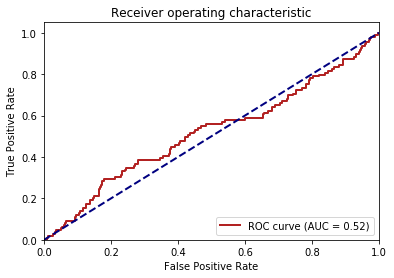

Average precision-recall score: 0.10
Best F1 score of  0.1871345029239766  achieved at threshold of  12105.897708912955


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


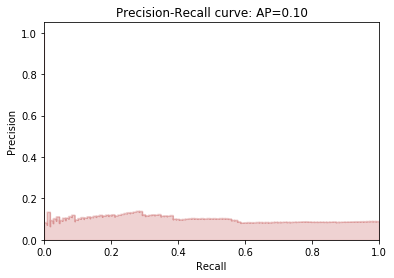

In [156]:
roc_auc, average_precision, F1_best, threshold_best = calc_metrics(y_gt_test, y_score_test, display_graphs=True)

In [258]:
print (mean_grid.shape)
mean_grid = np.multiply(mean_grid,255)
print(mean_grid.dtype)
cv2.imwrite("mean_grid.jpg", mean_grid.reshape((34,60)))




(1, 34, 60)
float64


True

In [259]:
maxi = np.amax(mean_grid)
print (maxi)

174.103716113311


## Multivariate Gaussian

In [157]:
def covariance_matrix(X):
    m, n = X.shape 
    tmp_mat = np.zeros((n, n))
    mu = X.mean(axis=0)
    for i in range(m):
        tmp_mat += np.outer(X[i] - mu, X[i] - mu)
    return tmp_mat / m

In [168]:
def multi_gauss_params(X):
    
    #cov_mat = covariance_matrix(X)
    cov_mat = np.cov(X, rowvar=False)
    print('Covariance matrix done')
    cov_mat_inv = np.linalg.pinv(cov_mat)
    print('Covariance matrix inverse done')
    (sign, logdet) = np.linalg.slogdet(cov_mat)
    print((sign, logdet))
    cov_mat_det = sign * np.exp(logdet)
    print('Covariance matrix determinant done')
    
    return cov_mat, cov_mat_inv, cov_mat_det


In [169]:
def multi_gauss(x, cov_mat, cov_mat_inv, cov_mat_det):
    n = len(cov_mat)
    return (np.exp(-0.5 * np.dot(x, np.dot(cov_mat_inv, x.T))) )
            #/ (2. * np.pi)**(n/2.) 
            #/ np.sqrt(cov_mat_det))

In [177]:


X_train_flat, X_test_flat = X_train.reshape((len(X_train), np.prod(X_train.shape[1:]))), X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

X_train_flat = np.array(X_train_flat, dtype=np.float64)
X_test_flat = np.array(X_test_flat, dtype=np.float64)

X_train_flat = np.multiply(X_train_flat, 2)
X_test_flat = np.multiply(X_test_flat, 2)

print(X_train_flat)


[[ 0.00243986  0.00139314  0.63524044 ...  0.03216659  0.01345346
   0.00550047]
 [ 0.00092935  0.00318979  0.50082946 ...  0.08357336  0.01005934
   0.06267357]
 [ 0.07098141  0.05775058  0.05842052 ... -0.09226781  0.08590843
  -0.02884808]
 ...
 [-0.05110478  0.2392251  -0.0223549  ... -0.04985155  0.27467558
  -0.04464532]
 [ 0.24928954  0.22939219  0.27906537 ...  0.08735906 -0.07782769
  -0.03434466]
 [ 0.42804277  0.0693409   0.43257183 ...  0.2794444  -0.30419627
   0.04734585]]


In [178]:
cov_mat, cov_mat_inv, cov_mat_det = multi_gauss_params(X_train_flat)



Covariance matrix done
Covariance matrix inverse done
(1.0, -14610.76566745767)
Covariance matrix determinant done


In [172]:
print(cov_mat_inv)
print(cov_mat_det)

[[ 1.31159976e+03 -1.30881489e+02 -7.43635036e+02 ...  2.97299327e+01
   9.12951394e+00 -1.05498928e+01]
 [-1.30881489e+02  2.94399888e+03  1.41587116e+02 ... -9.19109024e+01
  -9.49023361e-01  3.65197066e+01]
 [-7.43635036e+02  1.41587117e+02  1.08823924e+03 ... -5.38006003e+01
  -5.57437757e+00  2.03137523e+01]
 ...
 [ 2.97299327e+01 -9.19109021e+01 -5.38006002e+01 ...  5.19123917e+03
   2.29667050e+02 -1.72264699e+03]
 [ 9.12951393e+00 -9.49023318e-01 -5.57437756e+00 ...  2.29667050e+02
   1.65148698e+02 -2.42539534e+02]
 [-1.05498928e+01  3.65197064e+01  2.03137523e+01 ... -1.72264699e+03
  -2.42539534e+02  1.43283502e+03]]
0.0


In [244]:

threshold = 900

scores = np.zeros((X_test.shape[0]), dtype = np.float64)

dists = 0
j = 0
found_anomaly = False
interval = 2  # in seconds
interval_timer = 0
for i, (grid,frameId,second_count)   in enumerate(zip(X_test_flat,Id_test,sec_count_test)):
    grid_numeric = np.array(grid, dtype = np.float64)
    one_minus_prob = 1-multi_gauss(grid, cov_mat, cov_mat_inv, cov_mat_det)
    print(one_minus_prob)
    scores[i] = one_minus_prob
    dists = dists + one_minus_prob
    interval_timer = interval_timer+1 
    if one_minus_prob > threshold and found_anomaly == False:
        j = j+1
        found_anomaly = True
        interval_timer = 0
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')
    if interval_timer*seconds == interval and found_anomaly == True:
        found_anomaly = False
    


mean = dists/frameIds.size
print(mean)



y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])



1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999822058825
1.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


ROC_AUC: 0.48


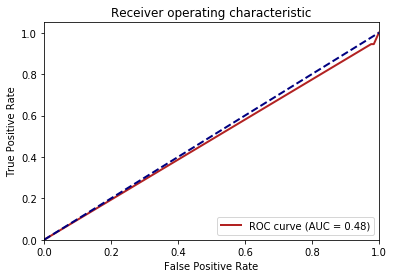

Average precision-recall score: 0.09
Best F1 score of  0.1626865671641791  achieved at threshold of  0.0


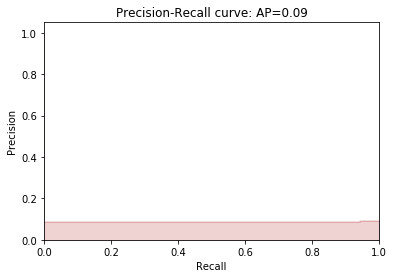

In [245]:
roc_auc, average_precision, F1_best, threshold_best = calc_metrics(y_gt_test, y_score_test, display_graphs=True)

### Modified Multivariate Gaussian

In [295]:
coordinates_train = []


for index, loc in np.ndenumerate(X_train):
    if loc == 1:
        if X_train.shape[1] == 2:
            coordinates_train.append([index[1],index[2],index[3]])
        else:
            coordinates_train.append([index[2],index[3]])


        
coordinates_train = np.array(coordinates_train, dtype=np.int8)


In [296]:
print(coordinates_train.shape)
print(coordinates_train.dtype)
print(coordinates_train)

(1248324, 2)
int8
[[ 1 49]
 [ 1 50]
 [ 2 49]
 ...
 [33 57]
 [33 58]
 [33 59]]


In [297]:
cov_mat, cov_mat_inv, cov_mat_det = multi_gauss_params(coordinates_train)




Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done


In [298]:
print(cov_mat_inv)
print(cov_mat_det)

[[ 0.01586887 -0.00058928]
 [-0.00058928  0.00432724]]
14636.768207038227


In [299]:

threshold = 900

scores = np.zeros((X_test.shape[0]), dtype = np.float64)

dists = 0
j = 0
found_anomaly = False
interval = 2  # in seconds
interval_timer = 0
for i, (grid,frameId,second_count)   in enumerate(zip(X_test,Id_test,sec_count_test)):
    probabilities = []
    
    for index, loc in np.ndenumerate(grid):
        if loc == 1:
            
            if X_train.shape[1] == 2:
                one_minus_prob = 1-multi_gauss(np.array([index[0],index[1],index[2]]), cov_mat, cov_mat_inv, cov_mat_det)
            else:
                one_minus_prob = 1-multi_gauss(np.array([index[1],index[2]]), cov_mat, cov_mat_inv, cov_mat_det)

            probabilities.append(one_minus_prob)
    
    if len(probabilities) > 0:
        score = max(probabilities)
    else:
        score = 0
    #print(score)
    scores[i] = score
    dists = dists + score
    interval_timer = interval_timer+1 
    if score > threshold and found_anomaly == False:
        j = j+1
        found_anomaly = True
        interval_timer = 0
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')
    if interval_timer*seconds == interval and found_anomaly == True:
        found_anomaly = False
    


mean = dists/frameIds.size
print(mean)



y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])




0.5987294655936111


ROC_AUC: 0.55


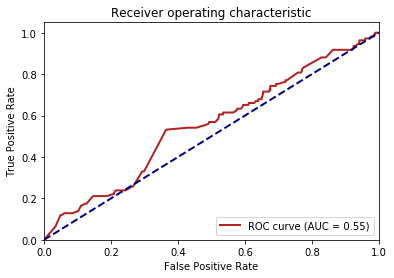

Average precision-recall score: 0.11
Best F1 score of  0.2013888888888889  achieved at threshold of  0.9999896688352592


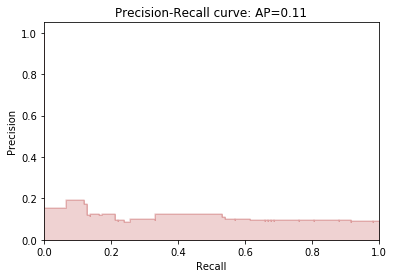

In [300]:
roc_auc, average_precision, F1_best, threshold_best = calc_metrics(y_gt_test, y_score_test, display_graphs=True)

## Autoencoder

### 1D Autoencoder

In [326]:


X_train_flat, X_test_flat = X_train.reshape((len(X_train), np.prod(X_train.shape[1:]))), X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))


In [327]:
input_dim = np.prod(grids.shape[1:])
encoding_dim = 14

print(input_dim)

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

4080


In [328]:
nb_epoch = 50
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="models/model.h5",
                               verbose=0,
                               save_best_only=True)


history = autoencoder.fit(X_train_flat, X_train_flat,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test_flat, X_test_flat),
                    verbose=1,
                    callbacks=[checkpointer]).history

Train on 6566 samples, validate on 9848 samples
Epoch 1/50
6566/6566 [==============================] - 5s 720us/step - loss: 0.0724 - acc: 0.0000e+00 - val_loss: 0.0713 - val_acc: 0.0000e+00
Epoch 2/50
6566/6566 [==============================] - 3s 412us/step - loss: 0.0649 - acc: 0.0000e+00 - val_loss: 0.0678 - val_acc: 0.0000e+00
Epoch 3/50
6566/6566 [==============================] - 3s 433us/step - loss: 0.0628 - acc: 0.0000e+00 - val_loss: 0.0670 - val_acc: 1.0154e-04
Epoch 4/50
6566/6566 [==============================] - 3s 442us/step - loss: 0.0612 - acc: 0.0000e+00 - val_loss: 0.0648 - val_acc: 5.0772e-04
Epoch 5/50
6566/6566 [==============================] - 3s 417us/step - loss: 0.0597 - acc: 0.0011 - val_loss: 0.0643 - val_acc: 1.0154e-04
Epoch 6/50
6566/6566 [==============================] - 3s 418us/step - loss: 0.0582 - acc: 0.0011 - val_loss: 0.0629 - val_acc: 2.0309e-04
Epoch 7/50
6566/6566 [==============================] - 3s 433us/step - loss: 0.0573 - acc: 3.04

In [329]:
autoencoder = load_model('models/model.h5')

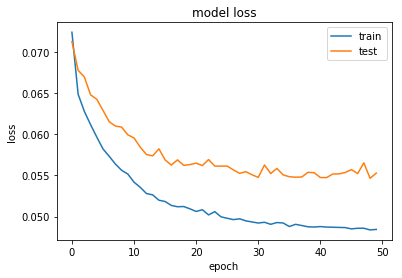

In [330]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [331]:
predictions = autoencoder.predict(X_test_flat)

In [332]:
mse = np.mean(np.power(X_test_flat - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'frameId': Id_test,
                        'second_count': sec_count_test})


In [333]:
threshold = 0.08
interval = 2  # in seconds

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
pred_frameIds = []
pred_second_counts = []
for y,frameId,sec_count in zip(y_pred, Id_test, sec_count_test):
    if y==1:
        pred_frameIds.append(frameId)
        pred_second_counts.append(sec_count)
pred_frameIds.sort()
pred_second_counts.sort()


for i, second_count in enumerate(pred_second_counts):
    if second_count-pred_second_counts[max(i-1,0)] > interval:
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')
    


Anomaly detected at :  28  mins  18  seconds
Anomaly detected at :  28  mins  23  seconds
Anomaly detected at :  28  mins  59  seconds
Anomaly detected at :  29  mins  5  seconds
Anomaly detected at :  29  mins  16  seconds
Anomaly detected at :  29  mins  50  seconds
Anomaly detected at :  30  mins  0  seconds
Anomaly detected at :  30  mins  5  seconds
Anomaly detected at :  30  mins  12  seconds
Anomaly detected at :  30  mins  51  seconds
Anomaly detected at :  31  mins  4  seconds
Anomaly detected at :  31  mins  10  seconds
Anomaly detected at :  31  mins  53  seconds
Anomaly detected at :  32  mins  2  seconds
Anomaly detected at :  32  mins  8  seconds
Anomaly detected at :  32  mins  37  seconds
Anomaly detected at :  32  mins  59  seconds
Anomaly detected at :  33  mins  35  seconds
Anomaly detected at :  33  mins  43  seconds
Anomaly detected at :  35  mins  30  seconds
Anomaly detected at :  36  mins  10  seconds
Anomaly detected at :  37  mins  8  seconds
Anomaly detected 

In [334]:


y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(error_df.reconstruction_error.values[clip_size*i:clip_size*(i+1)])
    

ROC_AUC: 0.48


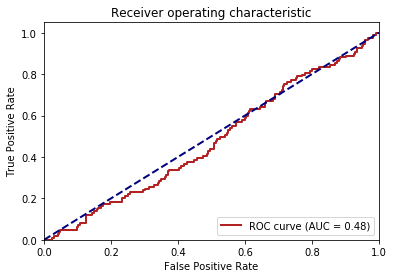

Average precision-recall score: 0.08


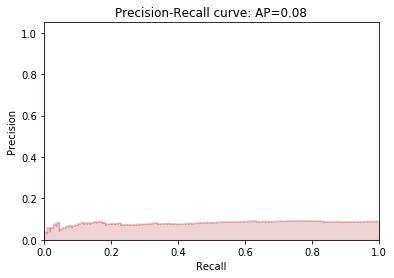

In [335]:
roc_auc, average_precision, F1_best, threshold_best = calc_metrics(y_gt_test, y_score_test, display_graphs=True)

### 2D Convolutional Autoencoder

In [336]:
input_dim = (grids.shape[1], grids.shape[2], grids.shape[3])

print(input_dim)


input_img = Input(shape=input_dim)  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same', data_format="channels_first")(input_img)
x = MaxPooling2D((2, 2), padding='same', data_format="channels_first")(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', data_format="channels_first")(x)
x = MaxPooling2D((2, 2), padding='same', data_format="channels_first")(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', data_format="channels_first")(x)
encoded = MaxPooling2D((2, 2), padding='same', data_format="channels_first")(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same', data_format="channels_first")(encoded)
x = UpSampling2D((2, 2), data_format="channels_first")(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', data_format="channels_first")(x)
x = UpSampling2D((2, 2), data_format="channels_first")(x)
x = Conv2D(16, (4, 3), activation='relu', data_format="channels_first")(x)
x = UpSampling2D((2, 2), data_format="channels_first")(x)
decoded = Conv2D(grids.shape[1], (3, 3), activation='sigmoid', padding='same', data_format="channels_first")(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

(2, 34, 60)


In [337]:
checkpointer = ModelCheckpoint(filepath="models/model_2D_conv.h5",
                               verbose=0,
                               save_best_only=True)


history = autoencoder.fit(X_train, X_train,
                epochs=4,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[checkpointer]).history

Train on 6566 samples, validate on 9848 samples
Epoch 1/4
6566/6566 [==============================] - 173s 26ms/step - loss: 0.2577 - val_loss: 0.1384
Epoch 2/4
6566/6566 [==============================] - 175s 27ms/step - loss: 0.1114 - val_loss: 0.1017
Epoch 3/4
6566/6566 [==============================] - 177s 27ms/step - loss: 0.0934 - val_loss: 0.0927
Epoch 4/4
6566/6566 [==============================] - 171s 26ms/step - loss: 0.0867 - val_loss: 0.0876


In [56]:
autoencoder = load_model('models/model_2D_conv.h5')

In [57]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1, 34, 60)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 34, 60)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 17, 30)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 17, 30)         1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 9, 15)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 9, 15)          584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 5, 8)           0         
__________

In [58]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

NameError: name 'history' is not defined

In [59]:
predictions = autoencoder.predict(X_test)

In [60]:
mse = np.mean(np.power(X_test - predictions, 2), axis=(1,2,3))
print(mse.shape)
error_df = pd.DataFrame({'reconstruction_error': mse.reshape((len(mse),)),
                        'frameId': Id_test,
                        'second_count': sec_count_test})




(9848,)


In [61]:
threshold = 0.015
interval = 1

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
pred_frameIds = []
pred_second_counts = []
for y,frameId,sec_count in zip(y_pred, Id_test, sec_count_test):
    if y==1:
        pred_frameIds.append(frameId)
        pred_second_counts.append(sec_count)
pred_frameIds.sort()
pred_second_counts.sort()


for i, second_count in enumerate(pred_second_counts):
    if second_count-pred_second_counts[max(i-1,0)] > interval:
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')
    


    



Anomaly detected at :  36  mins  57  seconds
Anomaly detected at :  37  mins  1  seconds
Anomaly detected at :  37  mins  38  seconds
Anomaly detected at :  38  mins  53  seconds
Anomaly detected at :  38  mins  59  seconds
Anomaly detected at :  39  mins  50  seconds
Anomaly detected at :  39  mins  52  seconds
Anomaly detected at :  39  mins  56  seconds
Anomaly detected at :  40  mins  18  seconds
Anomaly detected at :  40  mins  21  seconds
Anomaly detected at :  44  mins  10  seconds
Anomaly detected at :  45  mins  42  seconds
Anomaly detected at :  46  mins  16  seconds
Anomaly detected at :  46  mins  20  seconds
Anomaly detected at :  46  mins  24  seconds
Anomaly detected at :  46  mins  27  seconds
Anomaly detected at :  46  mins  30  seconds
Anomaly detected at :  46  mins  32  seconds
Anomaly detected at :  46  mins  35  seconds
Anomaly detected at :  46  mins  40  seconds
Anomaly detected at :  46  mins  47  seconds
Anomaly detected at :  47  mins  11  seconds
Anomaly det

In [62]:


y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(error_df.reconstruction_error.values[clip_size*i:clip_size*(i+1)])
    

ROC_AUC: 0.52


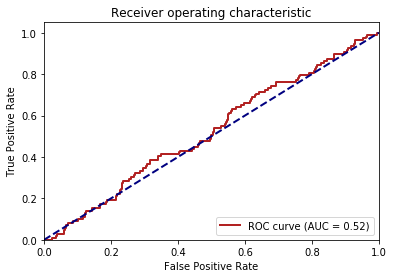

Average precision-recall score: 0.09
Best F1 score of  0.17218543046357618  achieved at threshold of  0.02560015767812729


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


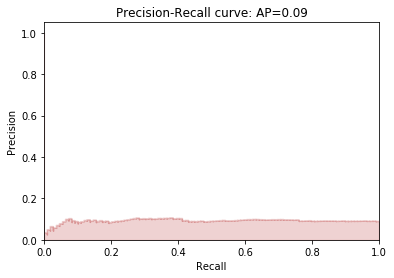

In [63]:
roc_auc, average_precision, F1_best, threshold_best = calc_metrics(y_gt_test, y_score_test, display_graphs=True)

## Region Based Approach

### Variance

In [100]:
vertical_divisions = 10  # Actual number of divisions will vary after precision loss from rounding
horizontal_divisions = 10

#region_w = int(round(X_train.shape[3]/horizontal_divisions))
#region_h = int(round(X_train.shape[2]/vertical_divisions))

region_w = 3
region_h = 3



In [101]:

region_scores = np.zeros((X_test.shape[0],int(ceil(X_train.shape[2]/region_h)),int(ceil(X_train.shape[3]/region_w))), dtype = np.float64)
region_scores.shape


(9848, 20, 1)

In [106]:
mean_grid = np.mean(X_train, axis=0)
print(X_train.shape)


for i in range(int(ceil(X_train.shape[3]/region_w))): # horizontal index
    for j in range(int(ceil(X_train.shape[2]/region_h))): # vertical index

        X_train_r = X_train[:,:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
        X_test_r = X_test[:,:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
        # print('(',region_h*j,'-',region_h*(j+1),')   (',region_w*i,'-',region_w*(i+1),')')
        
        mean_grid_r = mean_grid[:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
        
        
        ######################################################################
        
        
        print(X_test_r.shape)
        var = np.mean(np.amax(np.power(X_test_r - mean_grid_r, 2), axis=1), axis=(1,2))
        error_df = pd.DataFrame({'variance': var})
        
        region_scores[:,j,i] = error_df.variance.values




        

(6566, 34, 60, 2)
(9848, 34, 3, 2)
(9848, 34, 3, 2)
(9848, 34, 3, 2)
(9848, 34, 3, 2)
(9848, 34, 3, 2)
(9848, 34, 3, 2)
(9848, 34, 3, 2)
(9848, 34, 3, 2)
(9848, 34, 3, 2)
(9848, 34, 3, 2)
(9848, 34, 3, 2)
(9848, 34, 3, 2)
(9848, 34, 3, 2)
(9848, 34, 3, 2)
(9848, 34, 3, 2)
(9848, 34, 3, 2)
(9848, 34, 3, 2)
(9848, 34, 3, 2)
(9848, 34, 3, 2)
(9848, 34, 3, 2)


In [103]:
scores = np.amax(region_scores, axis=(1,2))

y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])
    

ROC_AUC: 0.55


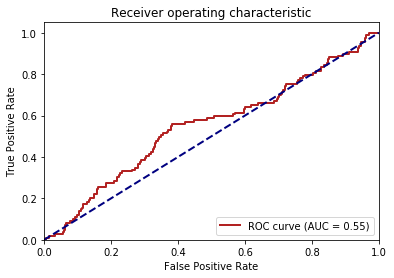

Average precision-recall score: 0.10
Best F1 score of  0.2040133779264214  achieved at threshold of  0.6524067521095276


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


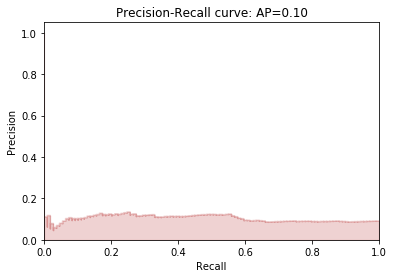

In [104]:
roc_auc, average_precision, F1_best, threshold_best = calc_metrics(y_gt_test, y_score_test, display_graphs=True)

In [494]:
threshold = 0.4
interval = 1

y_pred = [1 if e > threshold else 0 for e in scores]
pred_frameIds = []
pred_second_counts = []
for y,frameId,sec_count in zip(y_pred, Id_test, sec_count_test):
    if y==1:
        pred_frameIds.append(frameId)
        pred_second_counts.append(sec_count)
pred_frameIds.sort()
pred_second_counts.sort()


for i, second_count in enumerate(pred_second_counts):
    if second_count-pred_second_counts[max(i-1,0)] > interval:
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')

Anomaly detected at :  27  mins  35  seconds
Anomaly detected at :  27  mins  41  seconds
Anomaly detected at :  29  mins  22  seconds
Anomaly detected at :  29  mins  24  seconds
Anomaly detected at :  29  mins  36  seconds
Anomaly detected at :  29  mins  45  seconds
Anomaly detected at :  41  mins  42  seconds
Anomaly detected at :  43  mins  21  seconds
Anomaly detected at :  46  mins  49  seconds
Anomaly detected at :  56  mins  56  seconds
Anomaly detected at :  56  mins  58  seconds
Anomaly detected at :  66  mins  13  seconds
Anomaly detected at :  66  mins  15  seconds
Anomaly detected at :  67  mins  32  seconds


### Autoencoder

In [389]:

region_scores = np.zeros((X_test.shape[0],int(ceil(X_train.shape[2]/region_h)),int(ceil(X_train.shape[3]/region_w))), dtype = np.float64)
region_scores.shape


(9848, 12, 10)

In [390]:
for i in range(int(ceil(X_train.shape[3]/region_w))): # horizontal index
    for j in range(int(ceil(X_train.shape[2]/region_h))): # vertical index

        X_train_r = X_train[:,:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
        X_test_r = X_test[:,:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
        # print('(',region_h*j,'-',region_h*(j+1),')   (',region_w*i,'-',region_w*(i+1),')')
        
        X_train_r_flat = X_train_r.reshape((len(X_train_r), np.prod(X_train_r.shape[1:])))
        X_test_r_flat = X_test_r.reshape((len(X_test_r), np.prod(X_test_r.shape[1:])))
        
        ######################################################################
        
        input_dim = np.prod(X_train_r.shape[1:])
        encoding_dim = int(round(input_dim/2))

        # print(input_dim)

        input_layer = Input(shape=(input_dim, ))

        encoder = Dense(encoding_dim, activation="tanh", 
                        activity_regularizer=regularizers.l1(10e-5))(input_layer)
        encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

        decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
        decoder = Dense(input_dim, activation='relu')(decoder)

        autoencoder = Model(inputs=input_layer, outputs=decoder)
        
        nb_epoch = 10
        batch_size = 32

        autoencoder.compile(optimizer='adam', 
                            loss='mean_squared_error', 
                            metrics=['accuracy'])

        checkpointer = ModelCheckpoint(filepath="models/model_r.h5",
                                       verbose=0,
                                       save_best_only=True)


        history = autoencoder.fit(X_train_r_flat, X_train_r_flat,
                            epochs=nb_epoch,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=(X_test_r_flat, X_test_r_flat),
                            verbose=1,
                            callbacks=[checkpointer]).history
        
        autoencoder = load_model('models/model_r.h5')
        
        predictions = autoencoder.predict(X_test_r_flat)
        
        mse = np.mean(np.power(X_test_r_flat - predictions, 2), axis=1)
        error_df = pd.DataFrame({'reconstruction_error': mse})
        
        region_scores[:,j,i] = error_df.reconstruction_error.values




        

Train on 6566 samples, validate on 9848 samples
Epoch 1/10
6566/6566 [==============================] - 8s 1ms/step - loss: 6.1425e-05 - acc: 0.8291 - val_loss: 3.5190e-05 - val_acc: 0.9998
Epoch 2/10
6566/6566 [==============================] - 2s 280us/step - loss: 5.4233e-05 - acc: 0.8340 - val_loss: 2.7312e-05 - val_acc: 0.9998
Epoch 3/10
6566/6566 [==============================] - 2s 283us/step - loss: 4.5506e-05 - acc: 0.8096 - val_loss: 2.5167e-05 - val_acc: 0.9998
Epoch 4/10
6566/6566 [==============================] - 2s 264us/step - loss: 3.5733e-05 - acc: 0.8136 - val_loss: 2.3955e-05 - val_acc: 0.0000e+00
Epoch 5/10
6566/6566 [==============================] - 2s 263us/step - loss: 2.6521e-05 - acc: 0.8672 - val_loss: 2.3393e-05 - val_acc: 0.0000e+00
Epoch 6/10
6566/6566 [==============================] - 2s 268us/step - loss: 2.3718e-05 - acc: 0.9024 - val_loss: 1.9896e-05 - val_acc: 0.9998
Epoch 7/10
6566/6566 [==============================] - 2s 272us/step - loss: 2.07

Epoch 8/10
6566/6566 [==============================] - 2s 283us/step - loss: 0.0197 - acc: 0.1241 - val_loss: 0.0137 - val_acc: 0.0836
Epoch 9/10
6566/6566 [==============================] - 2s 284us/step - loss: 0.0187 - acc: 0.0853 - val_loss: 0.0128 - val_acc: 0.0606
Epoch 10/10
6566/6566 [==============================] - 2s 282us/step - loss: 0.0180 - acc: 0.1066 - val_loss: 0.0120 - val_acc: 0.0609
Train on 6566 samples, validate on 9848 samples
Epoch 1/10
6566/6566 [==============================] - 9s 1ms/step - loss: 0.0378 - acc: 0.0417 - val_loss: 0.0311 - val_acc: 0.0234
Epoch 2/10
6566/6566 [==============================] - 2s 290us/step - loss: 0.0279 - acc: 0.0366 - val_loss: 0.0265 - val_acc: 0.0121
Epoch 3/10
6566/6566 [==============================] - 2s 287us/step - loss: 0.0234 - acc: 0.0597 - val_loss: 0.0252 - val_acc: 0.8441
Epoch 4/10
6566/6566 [==============================] - 2s 285us/step - loss: 0.0214 - acc: 0.1390 - val_loss: 0.0244 - val_acc: 0.0159
E

6566/6566 [==============================] - 2s 319us/step - loss: 0.0177 - acc: 0.2219 - val_loss: 0.0189 - val_acc: 0.8786
Epoch 7/10
6566/6566 [==============================] - 2s 321us/step - loss: 0.0175 - acc: 0.3014 - val_loss: 0.0187 - val_acc: 0.0042
Epoch 8/10
6566/6566 [==============================] - 2s 319us/step - loss: 0.0174 - acc: 0.2507 - val_loss: 0.0186 - val_acc: 0.0042
Epoch 9/10
6566/6566 [==============================] - 2s 318us/step - loss: 0.0173 - acc: 0.3226 - val_loss: 0.0185 - val_acc: 0.0042
Epoch 10/10
6566/6566 [==============================] - 2s 316us/step - loss: 0.0172 - acc: 0.4819 - val_loss: 0.0185 - val_acc: 0.0042
Train on 6566 samples, validate on 9848 samples
Epoch 1/10
6566/6566 [==============================] - 11s 2ms/step - loss: 1.9358e-04 - acc: 0.5061 - val_loss: 4.1222e-05 - val_acc: 1.0154e-04
Epoch 2/10
6566/6566 [==============================] - 3s 421us/step - loss: 1.6680e-04 - acc: 0.5649 - val_loss: 3.8630e-05 - val_acc

6566/6566 [==============================] - 2s 350us/step - loss: 0.0329 - acc: 0.1416 - val_loss: 0.0313 - val_acc: 0.0978
Epoch 4/10
6566/6566 [==============================] - 2s 348us/step - loss: 0.0252 - acc: 0.1345 - val_loss: 0.0258 - val_acc: 0.0793
Epoch 5/10
6566/6566 [==============================] - 2s 347us/step - loss: 0.0212 - acc: 0.1250 - val_loss: 0.0219 - val_acc: 0.0964
Epoch 6/10
6566/6566 [==============================] - 2s 348us/step - loss: 0.0181 - acc: 0.1237 - val_loss: 0.0192 - val_acc: 0.0859
Epoch 7/10
6566/6566 [==============================] - 2s 346us/step - loss: 0.0161 - acc: 0.1301 - val_loss: 0.0175 - val_acc: 0.0849
Epoch 8/10
6566/6566 [==============================] - 2s 353us/step - loss: 0.0147 - acc: 0.1316 - val_loss: 0.0166 - val_acc: 0.0832
Epoch 9/10
6566/6566 [==============================] - 2s 349us/step - loss: 0.0138 - acc: 0.1287 - val_loss: 0.0157 - val_acc: 0.0746
Epoch 10/10
6566/6566 [==============================] - 2s

6566/6566 [==============================] - 12s 2ms/step - loss: 0.0382 - acc: 0.0999 - val_loss: 0.0327 - val_acc: 0.0911
Epoch 2/10
6566/6566 [==============================] - 2s 368us/step - loss: 0.0355 - acc: 0.2575 - val_loss: 0.0324 - val_acc: 0.0100
Epoch 3/10
6566/6566 [==============================] - 2s 378us/step - loss: 0.0352 - acc: 0.3200 - val_loss: 0.0320 - val_acc: 0.1035
Epoch 4/10
6566/6566 [==============================] - 2s 371us/step - loss: 0.0348 - acc: 0.3017 - val_loss: 0.0317 - val_acc: 0.0323
Epoch 5/10
6566/6566 [==============================] - 2s 372us/step - loss: 0.0345 - acc: 0.1147 - val_loss: 0.0314 - val_acc: 0.1035
Epoch 6/10
6566/6566 [==============================] - 2s 372us/step - loss: 0.0343 - acc: 0.1392 - val_loss: 0.0311 - val_acc: 0.0323
Epoch 7/10
6566/6566 [==============================] - 2s 378us/step - loss: 0.0341 - acc: 0.0632 - val_loss: 0.0309 - val_acc: 0.0323
Epoch 8/10
6566/6566 [==============================] - 2s 3

Epoch 9/10
6566/6566 [==============================] - 3s 411us/step - loss: 0.0108 - acc: 0.1829 - val_loss: 0.0145 - val_acc: 0.0863
Epoch 10/10
6566/6566 [==============================] - 3s 414us/step - loss: 0.0103 - acc: 0.1764 - val_loss: 0.0140 - val_acc: 0.0946
Train on 6566 samples, validate on 9848 samples
Epoch 1/10
6566/6566 [==============================] - 13s 2ms/step - loss: 0.0347 - acc: 0.0149 - val_loss: 0.0327 - val_acc: 0.0173
Epoch 2/10
6566/6566 [==============================] - 3s 413us/step - loss: 0.0270 - acc: 0.0155 - val_loss: 0.0299 - val_acc: 0.0222
Epoch 3/10
6566/6566 [==============================] - 3s 415us/step - loss: 0.0234 - acc: 0.0151 - val_loss: 0.0235 - val_acc: 0.0241
Epoch 4/10
6566/6566 [==============================] - 3s 421us/step - loss: 0.0179 - acc: 0.0222 - val_loss: 0.0164 - val_acc: 0.0303
Epoch 5/10
6566/6566 [==============================] - 3s 410us/step - loss: 0.0141 - acc: 0.0423 - val_loss: 0.0138 - val_acc: 0.0993


6566/6566 [==============================] - 3s 444us/step - loss: 0.0095 - acc: 0.6427 - val_loss: 0.0064 - val_acc: 0.0147
Epoch 8/10
6566/6566 [==============================] - 3s 444us/step - loss: 0.0066 - acc: 0.3137 - val_loss: 0.0061 - val_acc: 0.0105
Epoch 9/10
6566/6566 [==============================] - 3s 443us/step - loss: 0.0063 - acc: 0.4683 - val_loss: 0.0059 - val_acc: 0.0149
Epoch 10/10
6566/6566 [==============================] - 3s 447us/step - loss: 0.0062 - acc: 0.4482 - val_loss: 0.0058 - val_acc: 0.8654
Train on 6566 samples, validate on 9848 samples
Epoch 1/10
6566/6566 [==============================] - 15s 2ms/step - loss: 0.0187 - acc: 0.1951 - val_loss: 0.0079 - val_acc: 0.0755
Epoch 2/10
6566/6566 [==============================] - 3s 450us/step - loss: 0.0085 - acc: 0.0899 - val_loss: 0.0067 - val_acc: 0.0754
Epoch 3/10
6566/6566 [==============================] - 3s 448us/step - loss: 0.0078 - acc: 0.1547 - val_loss: 0.0065 - val_acc: 0.0755
Epoch 4/10


6566/6566 [==============================] - 3s 483us/step - loss: 0.0237 - acc: 0.1439 - val_loss: 0.0239 - val_acc: 0.1527
Epoch 5/10
6566/6566 [==============================] - 3s 486us/step - loss: 0.0206 - acc: 0.1489 - val_loss: 0.0197 - val_acc: 0.1470
Epoch 6/10
6566/6566 [==============================] - 3s 486us/step - loss: 0.0168 - acc: 0.3354 - val_loss: 0.0174 - val_acc: 0.1427
Epoch 7/10
6566/6566 [==============================] - 3s 487us/step - loss: 0.0157 - acc: 0.5070 - val_loss: 0.0166 - val_acc: 0.7618
Epoch 8/10
6566/6566 [==============================] - 3s 492us/step - loss: 0.0149 - acc: 0.7221 - val_loss: 0.0158 - val_acc: 0.7632
Epoch 9/10
6566/6566 [==============================] - 3s 484us/step - loss: 0.0143 - acc: 0.7868 - val_loss: 0.0152 - val_acc: 0.7595
Epoch 10/10
6566/6566 [==============================] - 3s 487us/step - loss: 0.0139 - acc: 0.7895 - val_loss: 0.0148 - val_acc: 0.7679
Train on 6566 samples, validate on 9848 samples
Epoch 1/10

6566/6566 [==============================] - 4s 540us/step - loss: 0.0130 - acc: 0.2041 - val_loss: 0.0105 - val_acc: 0.0408
Epoch 3/10
6566/6566 [==============================] - 4s 541us/step - loss: 0.0113 - acc: 0.4007 - val_loss: 0.0094 - val_acc: 0.9414
Epoch 4/10
6566/6566 [==============================] - 4s 535us/step - loss: 0.0102 - acc: 0.4580 - val_loss: 0.0088 - val_acc: 0.9348
Epoch 5/10
6566/6566 [==============================] - 4s 538us/step - loss: 0.0096 - acc: 0.4974 - val_loss: 0.0083 - val_acc: 0.0363
Epoch 6/10
6566/6566 [==============================] - 4s 542us/step - loss: 0.0081 - acc: 0.3043 - val_loss: 0.0057 - val_acc: 0.0313
Epoch 7/10
6566/6566 [==============================] - 4s 542us/step - loss: 0.0062 - acc: 0.4199 - val_loss: 0.0052 - val_acc: 0.9054
Epoch 8/10
6566/6566 [==============================] - 4s 535us/step - loss: 0.0056 - acc: 0.3594 - val_loss: 0.0050 - val_acc: 0.0152
Epoch 9/10
6566/6566 [==============================] - 4s 

Epoch 10/10
6566/6566 [==============================] - 4s 573us/step - loss: 0.0087 - acc: 0.4275 - val_loss: 0.0127 - val_acc: 0.0671
Train on 6566 samples, validate on 9848 samples
Epoch 1/10
6566/6566 [==============================] - 19s 3ms/step - loss: 0.0503 - acc: 0.0309 - val_loss: 0.0545 - val_acc: 0.0903
Epoch 2/10
6566/6566 [==============================] - 4s 583us/step - loss: 0.0376 - acc: 0.0752 - val_loss: 0.0446 - val_acc: 0.1009
Epoch 3/10
6566/6566 [==============================] - 4s 577us/step - loss: 0.0278 - acc: 0.1011 - val_loss: 0.0325 - val_acc: 0.1329
Epoch 4/10
6566/6566 [==============================] - 4s 588us/step - loss: 0.0204 - acc: 0.1148 - val_loss: 0.0271 - val_acc: 0.1219
Epoch 5/10
6566/6566 [==============================] - 4s 585us/step - loss: 0.0169 - acc: 0.1435 - val_loss: 0.0226 - val_acc: 0.1179
Epoch 6/10
6566/6566 [==============================] - 4s 583us/step - loss: 0.0150 - acc: 0.2271 - val_loss: 0.0212 - val_acc: 0.6849


6566/6566 [==============================] - 4s 623us/step - loss: 0.0127 - acc: 0.3995 - val_loss: 0.0123 - val_acc: 0.0518
Epoch 9/10
6566/6566 [==============================] - 4s 621us/step - loss: 0.0123 - acc: 0.2994 - val_loss: 0.0121 - val_acc: 0.0384
Epoch 10/10
6566/6566 [==============================] - 4s 617us/step - loss: 0.0120 - acc: 0.5355 - val_loss: 0.0117 - val_acc: 0.0397
Train on 6566 samples, validate on 9848 samples
Epoch 1/10
6566/6566 [==============================] - 20s 3ms/step - loss: 0.0318 - acc: 0.0493 - val_loss: 0.0202 - val_acc: 0.0381
Epoch 2/10
6566/6566 [==============================] - 4s 630us/step - loss: 0.0187 - acc: 0.0663 - val_loss: 0.0144 - val_acc: 0.0472
Epoch 3/10
6566/6566 [==============================] - 4s 633us/step - loss: 0.0140 - acc: 0.0745 - val_loss: 0.0097 - val_acc: 0.0488
Epoch 4/10
6566/6566 [==============================] - 4s 627us/step - loss: 0.0093 - acc: 0.3334 - val_loss: 0.0081 - val_acc: 0.8663
Epoch 5/10


6566/6566 [==============================] - 4s 657us/step - loss: 0.0200 - acc: 0.1675 - val_loss: 0.0240 - val_acc: 0.1920
Epoch 7/10
6566/6566 [==============================] - 4s 663us/step - loss: 0.0176 - acc: 0.1684 - val_loss: 0.0226 - val_acc: 0.1942
Epoch 8/10
6566/6566 [==============================] - 4s 656us/step - loss: 0.0162 - acc: 0.1930 - val_loss: 0.0214 - val_acc: 0.5516
Epoch 9/10
6566/6566 [==============================] - 4s 661us/step - loss: 0.0152 - acc: 0.3293 - val_loss: 0.0208 - val_acc: 0.5545
Epoch 10/10
6566/6566 [==============================] - 4s 670us/step - loss: 0.0144 - acc: 0.4510 - val_loss: 0.0198 - val_acc: 0.5561
Train on 6566 samples, validate on 9848 samples
Epoch 1/10
6566/6566 [==============================] - 22s 3ms/step - loss: 0.0596 - acc: 0.0399 - val_loss: 0.0565 - val_acc: 0.0719
Epoch 2/10
6566/6566 [==============================] - 4s 676us/step - loss: 0.0446 - acc: 0.0599 - val_loss: 0.0457 - val_acc: 0.1033
Epoch 3/10


6566/6566 [==============================] - 5s 713us/step - loss: 0.0240 - acc: 0.1723 - val_loss: 0.0263 - val_acc: 0.6923
Epoch 5/10
6566/6566 [==============================] - 5s 718us/step - loss: 0.0221 - acc: 0.1770 - val_loss: 0.0249 - val_acc: 0.0548
Epoch 6/10
6566/6566 [==============================] - 5s 720us/step - loss: 0.0208 - acc: 0.0457 - val_loss: 0.0236 - val_acc: 0.0458
Epoch 7/10
6566/6566 [==============================] - 5s 719us/step - loss: 0.0194 - acc: 0.0906 - val_loss: 0.0223 - val_acc: 0.6823
Epoch 8/10
6566/6566 [==============================] - 5s 719us/step - loss: 0.0183 - acc: 0.5675 - val_loss: 0.0213 - val_acc: 0.6626
Epoch 9/10
6566/6566 [==============================] - 5s 716us/step - loss: 0.0176 - acc: 0.6177 - val_loss: 0.0208 - val_acc: 0.6604
Epoch 10/10
6566/6566 [==============================] - 5s 712us/step - loss: 0.0171 - acc: 0.6179 - val_loss: 0.0202 - val_acc: 0.6640
Train on 6566 samples, validate on 9848 samples
Epoch 1/10

6566/6566 [==============================] - 5s 741us/step - loss: 0.0847 - acc: 0.2301 - val_loss: 0.0838 - val_acc: 0.2362
Epoch 3/10
6566/6566 [==============================] - 5s 746us/step - loss: 0.0699 - acc: 0.2563 - val_loss: 0.0710 - val_acc: 0.2217
Epoch 4/10
6566/6566 [==============================] - 5s 753us/step - loss: 0.0610 - acc: 0.2519 - val_loss: 0.0664 - val_acc: 0.2187
Epoch 5/10
6566/6566 [==============================] - 5s 748us/step - loss: 0.0576 - acc: 0.2554 - val_loss: 0.0628 - val_acc: 0.2546
Epoch 6/10
6566/6566 [==============================] - 5s 758us/step - loss: 0.0548 - acc: 0.2553 - val_loss: 0.0601 - val_acc: 0.4205
Epoch 7/10
6566/6566 [==============================] - 5s 752us/step - loss: 0.0526 - acc: 0.2837 - val_loss: 0.0583 - val_acc: 0.4424
Epoch 8/10
6566/6566 [==============================] - 5s 747us/step - loss: 0.0510 - acc: 0.3579 - val_loss: 0.0567 - val_acc: 0.4790
Epoch 9/10
6566/6566 [==============================] - 5s 

6566/6566 [==============================] - 5s 795us/step - loss: 0.0106 - acc: 0.6412 - val_loss: 0.0114 - val_acc: 0.6378
Train on 6566 samples, validate on 9848 samples
Epoch 1/10
6566/6566 [==============================] - 26s 4ms/step - loss: 0.0945 - acc: 0.0583 - val_loss: 0.0691 - val_acc: 0.0247
Epoch 2/10
6566/6566 [==============================] - 5s 802us/step - loss: 0.0591 - acc: 0.0474 - val_loss: 0.0449 - val_acc: 0.0409
Epoch 3/10
6566/6566 [==============================] - 5s 804us/step - loss: 0.0398 - acc: 0.0551 - val_loss: 0.0353 - val_acc: 0.0328
Epoch 4/10
6566/6566 [==============================] - 5s 790us/step - loss: 0.0355 - acc: 0.0524 - val_loss: 0.0329 - val_acc: 0.0279
Epoch 5/10
6566/6566 [==============================] - 5s 810us/step - loss: 0.0334 - acc: 0.0507 - val_loss: 0.0312 - val_acc: 0.0329
Epoch 6/10
6566/6566 [==============================] - 5s 798us/step - loss: 0.0318 - acc: 0.1828 - val_loss: 0.0297 - val_acc: 0.0374
Epoch 7/10
6

6566/6566 [==============================] - 6s 847us/step - loss: 0.0264 - acc: 0.6975 - val_loss: 0.0292 - val_acc: 0.5748
Epoch 9/10
6566/6566 [==============================] - 6s 846us/step - loss: 0.0254 - acc: 0.4120 - val_loss: 0.0286 - val_acc: 0.5617
Epoch 10/10
6566/6566 [==============================] - 6s 842us/step - loss: 0.0244 - acc: 0.4045 - val_loss: 0.0277 - val_acc: 0.5613
Train on 6566 samples, validate on 9848 samples
Epoch 1/10
6566/6566 [==============================] - 28s 4ms/step - loss: 0.0982 - acc: 0.0725 - val_loss: 0.0739 - val_acc: 0.0476
Epoch 2/10
6566/6566 [==============================] - 6s 859us/step - loss: 0.0510 - acc: 0.0632 - val_loss: 0.0506 - val_acc: 0.0452
Epoch 3/10
6566/6566 [==============================] - 6s 855us/step - loss: 0.0364 - acc: 0.0615 - val_loss: 0.0409 - val_acc: 0.0479
Epoch 4/10
6566/6566 [==============================] - 6s 854us/step - loss: 0.0304 - acc: 0.0634 - val_loss: 0.0362 - val_acc: 0.0473
Epoch 5/10


6566/6566 [==============================] - 6s 889us/step - loss: 0.0172 - acc: 0.2286 - val_loss: 0.0211 - val_acc: 0.7573
Epoch 7/10
6566/6566 [==============================] - 6s 886us/step - loss: 0.0147 - acc: 0.2772 - val_loss: 0.0182 - val_acc: 0.0700
Epoch 8/10
6566/6566 [==============================] - 6s 888us/step - loss: 0.0133 - acc: 0.1687 - val_loss: 0.0153 - val_acc: 0.0768
Epoch 9/10
6566/6566 [==============================] - 6s 894us/step - loss: 0.0114 - acc: 0.2422 - val_loss: 0.0146 - val_acc: 0.7483
Epoch 10/10
6566/6566 [==============================] - 6s 889us/step - loss: 0.0109 - acc: 0.4787 - val_loss: 0.0144 - val_acc: 0.0730
Train on 6566 samples, validate on 9848 samples
Epoch 1/10
6566/6566 [==============================] - 29s 4ms/step - loss: 0.0556 - acc: 0.0178 - val_loss: 0.0364 - val_acc: 0.0077
Epoch 2/10
6566/6566 [==============================] - 6s 896us/step - loss: 0.0379 - acc: 0.0190 - val_loss: 0.0301 - val_acc: 0.0100
Epoch 3/10


6566/6566 [==============================] - 6s 930us/step - loss: 0.0352 - acc: 0.1835 - val_loss: 0.0390 - val_acc: 0.1592
Epoch 5/10
6566/6566 [==============================] - 6s 937us/step - loss: 0.0301 - acc: 0.1995 - val_loss: 0.0349 - val_acc: 0.1376
Epoch 6/10
6566/6566 [==============================] - 6s 939us/step - loss: 0.0271 - acc: 0.1700 - val_loss: 0.0328 - val_acc: 0.1268
Epoch 7/10
6566/6566 [==============================] - 6s 940us/step - loss: 0.0251 - acc: 0.1464 - val_loss: 0.0304 - val_acc: 0.1282
Epoch 8/10
6566/6566 [==============================] - 6s 944us/step - loss: 0.0234 - acc: 0.1290 - val_loss: 0.0287 - val_acc: 0.1128
Epoch 9/10
6566/6566 [==============================] - 6s 937us/step - loss: 0.0204 - acc: 0.1389 - val_loss: 0.0255 - val_acc: 0.1499
Epoch 10/10
6566/6566 [==============================] - 6s 934us/step - loss: 0.0179 - acc: 0.1698 - val_loss: 0.0240 - val_acc: 0.1254
Train on 6566 samples, validate on 9848 samples
Epoch 1/10

6566/6566 [==============================] - 6s 948us/step - loss: 0.0281 - acc: 0.0224 - val_loss: 0.0270 - val_acc: 0.0170
Epoch 3/10
6566/6566 [==============================] - 6s 941us/step - loss: 0.0224 - acc: 0.3297 - val_loss: 0.0241 - val_acc: 0.7906
Epoch 4/10
6566/6566 [==============================] - 6s 951us/step - loss: 0.0186 - acc: 0.4502 - val_loss: 0.0208 - val_acc: 0.8041
Epoch 5/10
6566/6566 [==============================] - 6s 943us/step - loss: 0.0174 - acc: 0.4828 - val_loss: 0.0199 - val_acc: 0.8111
Epoch 6/10
6566/6566 [==============================] - 6s 946us/step - loss: 0.0166 - acc: 0.4746 - val_loss: 0.0194 - val_acc: 0.0408
Epoch 7/10
6566/6566 [==============================] - 6s 948us/step - loss: 0.0161 - acc: 0.6132 - val_loss: 0.0189 - val_acc: 0.8165
Epoch 8/10
6566/6566 [==============================] - 6s 942us/step - loss: 0.0156 - acc: 0.6337 - val_loss: 0.0186 - val_acc: 0.8176
Epoch 9/10
6566/6566 [==============================] - 6s 

Epoch 10/10
6566/6566 [==============================] - 7s 1ms/step - loss: 9.7709e-04 - acc: 0.4834 - val_loss: 5.0525e-04 - val_acc: 0.0094
Train on 6566 samples, validate on 9848 samples
Epoch 1/10
6566/6566 [==============================] - 35s 5ms/step - loss: 0.0388 - acc: 0.0679 - val_loss: 0.0266 - val_acc: 0.1584
Epoch 2/10
6566/6566 [==============================] - 7s 1ms/step - loss: 0.0184 - acc: 0.0765 - val_loss: 0.0154 - val_acc: 0.1295
Epoch 3/10
6566/6566 [==============================] - 7s 1ms/step - loss: 0.0132 - acc: 0.0708 - val_loss: 0.0121 - val_acc: 0.1380
Epoch 4/10
6566/6566 [==============================] - 7s 1ms/step - loss: 0.0109 - acc: 0.0722 - val_loss: 0.0100 - val_acc: 0.1331
Epoch 5/10
6566/6566 [==============================] - 7s 1ms/step - loss: 0.0094 - acc: 0.0708 - val_loss: 0.0087 - val_acc: 0.1339
Epoch 6/10
6566/6566 [==============================] - 7s 1ms/step - loss: 0.0085 - acc: 0.1220 - val_loss: 0.0078 - val_acc: 0.1355
Epoc

Epoch 9/10
6566/6566 [==============================] - 7s 1ms/step - loss: 0.0074 - acc: 0.2871 - val_loss: 0.0079 - val_acc: 0.8427
Epoch 10/10
6566/6566 [==============================] - 7s 1ms/step - loss: 0.0072 - acc: 0.3616 - val_loss: 0.0076 - val_acc: 0.0191
Train on 6566 samples, validate on 9848 samples
Epoch 1/10
6566/6566 [==============================] - 37s 6ms/step - loss: 0.0347 - acc: 0.0411 - val_loss: 0.0351 - val_acc: 0.0270
Epoch 2/10
6566/6566 [==============================] - 7s 1ms/step - loss: 0.0225 - acc: 0.0303 - val_loss: 0.0220 - val_acc: 0.0197
Epoch 3/10
6566/6566 [==============================] - 7s 1ms/step - loss: 0.0168 - acc: 0.0425 - val_loss: 0.0174 - val_acc: 0.0416
Epoch 4/10
6566/6566 [==============================] - 7s 1ms/step - loss: 0.0133 - acc: 0.1588 - val_loss: 0.0138 - val_acc: 0.0372
Epoch 5/10
6566/6566 [==============================] - 7s 1ms/step - loss: 0.0115 - acc: 0.1252 - val_loss: 0.0134 - val_acc: 0.0409
Epoch 6/10
6

In [439]:
np.save("grid_arrays/region_scores_autoencoder.npy", region_scores)

In [49]:
region_scores = np.load("grid_arrays/region_scores_autoencoder.npy")

#### Average

In [50]:
scores = np.mean(region_scores, axis=(1,2))

y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])
    

ROC_AUC: 0.52


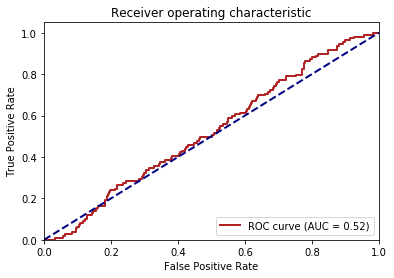

Average precision-recall score: 0.09
Best F1 score of  0.17472118959107807  achieved at threshold of  0.008271781704116568


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


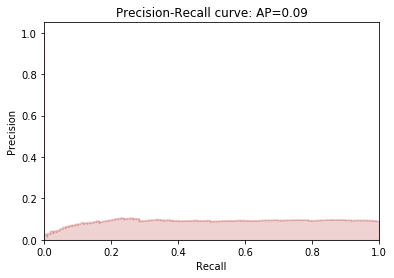

In [51]:
roc_auc, average_precision, F1_best, threshold_best = calc_metrics(y_gt_test, y_score_test, display_graphs=True)

#### Maximum

In [52]:
scores = np.amax(region_scores, axis=(1,2))

y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])
    

ROC_AUC: 0.52


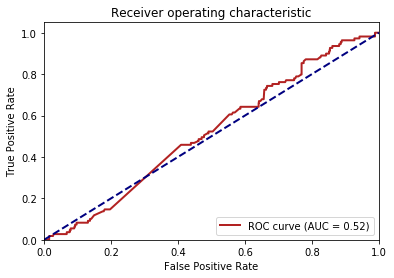

Average precision-recall score: 0.09
Best F1 score of  0.1757631822386679  achieved at threshold of  0.1692233383655548


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


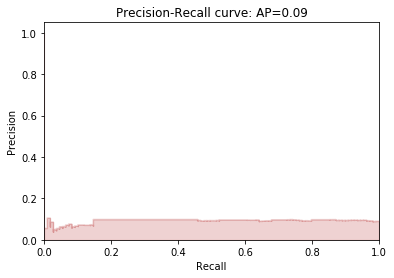

In [53]:
roc_auc, average_precision, F1_best, threshold_best = calc_metrics(y_gt_test, y_score_test, display_graphs=True)

#### Variance in Error

In [54]:
print(region_scores.shape)
mean_reg_score = np.amax(region_scores, axis=0)
print(mean_reg_score.shape)

y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)


scores = np.zeros((X_test.shape[0]), dtype = np.float64)


for i, (reg_score,frameId,second_count)   in enumerate(zip(region_scores,Id_test,sec_count_test)):
    reg_score_numeric = np.array(reg_score, dtype = np.float64)
    var_arr = np.subtract(mean_reg_score,reg_score_numeric)
    #print(var_arr)
    #if 0 in var_arr:
        #print('Found 0')
    #var_arr = np.divide(1,var_arr)
    #if len(var_arr[np.isinf(var_arr)]) > 0:
        #print('some elements')
    #var = distance.sqeuclidean(np.ravel(reg_score_numeric),np.ravel(mean_reg_score))
    #print(np.amax(var_arr))
    scores[i] = np.amax(var_arr)
    
#print(scores)
#scores = np.divide(1,scores)
#print(scores)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])
    

(9848, 12, 10)
(12, 10)


ROC_AUC: 0.48


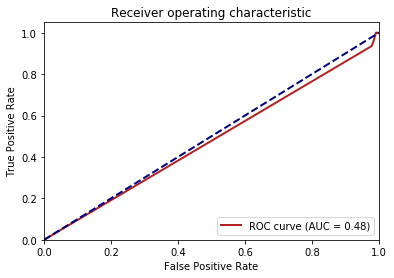

Average precision-recall score: 0.09
Best F1 score of  0.16390977443609023  achieved at threshold of  0.7427930859848857


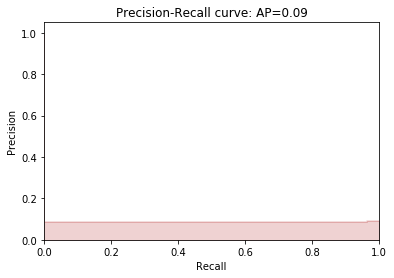

In [55]:
roc_auc, average_precision, F1_best, threshold_best = calc_metrics(y_gt_test, y_score_test, display_graphs=True)